In [1]:
import pandas as pd
import numpy as np

In [2]:
source_data = "Movies_and_TV"
target_data = "Books"

In [3]:
source_data_path = "../cross_data/processed_data_all/Movies_and_TV_train.csv"
target_data_path = "../cross_data/processed_data_all/Books_train.csv"
output_path = "../bmc_dataset/Movie-Books_reverse/"
# 不存在就创建文件夹
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)
# 测试，验证数据路径
valid_source_data_path = "../cross_data/processed_data_all/Movies_and_TV_valid.csv"
valid_target_data_path = "../cross_data/processed_data_all/Books_valid.csv"
test_source_data_path = "../cross_data/processed_data_all/Movies_and_TV_test.csv"
test_target_data_path = "../cross_data/processed_data_all/Books_test.csv"
source_neg_data_path  = "../cross_data/processed_data_all/Movies_and_TV_negative.csv"
target_neg_data_path = "../cross_data/processed_data_all/Books_negative.csv"

In [4]:
# 加载数据
# ts = timestamp 
# ouid = origin_uid
source_data = pd.read_csv(source_data_path,header=None,names=["uid","iid","ts","ouid","oiid"])
target_data = pd.read_csv(target_data_path,header=None,names=["uid","iid","ts","ouid","oiid"])


In [5]:
source_data

,uid,iid,ts,ouid,oiid
0,5797,231058,883785600,A30Q8X8B1S3GGT,6300215695
1,8134,233167,883785600,A3TQZ521KSRUZ1,6302098475
2,10556,273738,886377600,AVT9Q9PTUCDMR,B00000JSJ4
3,1144,236524,894844800,A1E5RX20ZJNFWJ,6303921248
4,8879,189082,895449600,AAHNPLJ1L109Y,1572522232
...,...,...,...,...,...
440451,24,379512,1405728000,A106YXO3EHVD3J,B009NNM77E
440452,10509,391878,1405728000,AV6QDP8Q0ONK4,B00JKN5JC2
440453,1967,379512,1405814400,A1OJF381IKR7LF,B009NNM77E
440454,1967,386041,1405814400,A1OJF381IKR7LF,B00DL482G6


In [6]:
target_data

,uid,iid,ts,ouid,oiid
0,7959,60556,835660800,A3RTKL9KB8KLID,044651862X
1,7959,75214,840240000,A3RTKL9KB8KLID,0553092626
2,7959,51574,843004800,A3RTKL9KB8KLID,0393316041
3,6440,14592,848016000,A38LAIK2N83NH0,0140231021
4,6440,18504,848275200,A38LAIK2N83NH0,0151179875
...,...,...,...,...,...
594049,5551,392330,1405987200,A2Y0RQNQHT5MZ8,B00KLERI50
594050,5551,392359,1405987200,A2Y0RQNQHT5MZ8,B00KP8AGRE
594051,5551,392360,1405987200,A2Y0RQNQHT5MZ8,B00KP8FDL8
594052,5551,392458,1405987200,A2Y0RQNQHT5MZ8,B00L2X36GE


In [7]:
# 要求两个领域的物品ID在一起重新编码，统计所有的物品ID信息，重新编码
def mapping_item_id(data):
    # 统计物品ID
    item_id = data["iid"].unique()
    # 重新编码
    # 从0开始编码
    item_id_map = dict(zip(item_id,range(len(item_id))))
    data["newiid"] = data["iid"].map(item_id_map)
    return data

def reencode_item_id(source_data,target_data):
    
    # 重新编码物品ID
    source_data = mapping_item_id(source_data)
    target_data = mapping_item_id(target_data)
    
    # 统计源域物品id的最大值
    max_source_item_id = source_data["newiid"].max()
    print("max_source_item_id:",max_source_item_id)
    # 在映射的基础上，添加上原来的物品ID
    # 编码从0开始，所以加1
    target_data["newiid"] = target_data["newiid"] + max_source_item_id + 1
    # 源领域还是之前的物品ID，不变

    
    # 保存物品的三个ID: iid oiid newiid映射关系到文件
    item_id_map_df_source = source_data[["iid","oiid","newiid"]].drop_duplicates()
    item_id_map_df_source.to_csv(output_path + "source_item_id_map.csv",index=False)
    item_id_map_df_source.to_csv(output_path + "Alist.txt",index=False,header=False)
    
    item_id_map_df_target = target_data[["iid","oiid","newiid"]].drop_duplicates()
    item_id_map_df_target.to_csv(output_path + "target_item_id_map.csv",index=False)
    item_id_map_df_target.to_csv(output_path + "Blist.txt",index=False,header=False)
    
    return source_data,target_data,max_source_item_id


In [8]:
# 混合源领域和目标领域的数据，将重新编码后的物品ID作为新的物品ID
def mix_source_target_train_data(source_data,target_data):
    mix_data = pd.concat([source_data,target_data],axis=0)
    mix_data = mix_data.sort_values(by=["uid","ts"])
    return mix_data

In [9]:
# 根据uid获取物品ID，保存为一条序列,只用于获取训练集!!
# 其中每条序列的格式是uid\tuid\tiid1|timestamp1|transtime\tiidi2|timestamp2|transtime ...
import datetime
def get_item_sequence(data):
    item_sequence = []
    for uid in data["uid"].unique():
        item_sequence.append([str(uid),str(uid)])
        for iid,ts in zip(data[data["uid"]==uid]["newiid"],data[data["uid"]==uid]["ts"]):
            item_sequence[-1].append(str(iid)+"|"+str(ts)+"|"+str(datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))+"|")
    return item_sequence



In [10]:
re_source_data,re_target_data, max_source_item_id = reencode_item_id(source_data,target_data)
mixed_data = mix_source_target_train_data(re_source_data,re_target_data)
res  = get_item_sequence(mixed_data)
res[0]

max_source_item_id: 59512


['1',
 '1',
 '89887|1369440000|2013-05-25 08:00:00|',
 '392|1372118400|2013-06-25 08:00:00|',
 '7117|1372118400|2013-06-25 08:00:00|',
 '9096|1372118400|2013-06-25 08:00:00|',
 '30808|1372118400|2013-06-25 08:00:00|',
 '40259|1372118400|2013-06-25 08:00:00|',
 '48116|1372118400|2013-06-25 08:00:00|',
 '188976|1372118400|2013-06-25 08:00:00|',
 '91136|1373414400|2013-07-10 08:00:00|',
 '27026|1374105600|2013-07-18 08:00:00|',
 '252344|1374105600|2013-07-18 08:00:00|',
 '64758|1374105600|2013-07-18 08:00:00|',
 '78079|1378512000|2013-09-07 08:00:00|',
 '59944|1378512000|2013-09-07 08:00:00|',
 '59577|1378512000|2013-09-07 08:00:00|',
 '90291|1378512000|2013-09-07 08:00:00|',
 '56919|1382659200|2013-10-25 08:00:00|',
 '47950|1391731200|2014-02-07 08:00:00|']

In [11]:
# 输出到文件中
with open(output_path+"traindata_new.txt","w") as f:
    for item in res:
        f.write("\t".join(item)+"\n")

In [12]:
# 对于测试集，验证集合，我们只需要使用训练数据的基础上拼接两个数据即可。
# 不过得首先判断一下，测试集合，验证集合中的用户是否在训练集合中出现过，去除在测试、验证集中没有出现的用户,并混合两个数据集
def filter_user4valid_test(data,valid_data):
    # 获取验证集的用户
    valid_users = valid_data["uid"].unique()
    # 过滤训练集的用户  
    data = data[data["uid"].isin(valid_users)]
    print("filter_data_user: ",len(data["uid"].unique()))
    # 混合两个数据集
    # 如果是多个同样的用户的话,那么要求训练集的物品序列必须重复多次.
    mix_data = pd.merge(left=valid_data,right=data,on="uid",how="left")   
    # uid iid ts ouid oiid newiid item_seq
    # 将验证集的数据插入到训练集的数据中item_seq中
    mix_data["item_seq"] = mix_data["item_seq"] + "\t" + mix_data["newiid"].map(str) + "|" + mix_data["ts"].map(str) + "|" + mix_data["ts"].map(lambda x:datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')) + "|"
    # 只保留uid item seq 返回
    
    return mix_data[["uid","item_seq"]]

In [13]:
#加载测试集，验证集
valid_source_data = pd.read_csv(valid_source_data_path,header=None,names=["uid","iid","ts","ouid","oiid"])
valid_target_data = pd.read_csv(valid_target_data_path,header=None,names=["uid","iid","ts","ouid","oiid"])
test_source_data = pd.read_csv(test_source_data_path,header=None,names=["uid","iid","ts","ouid","oiid"])
test_target_data = pd.read_csv(test_target_data_path,header=None,names=["uid","iid","ts","ouid","oiid"])

# 加载item_mapping 文件，重新编码物品ID
source_item_id_map = pd.read_csv(output_path + "source_item_id_map.csv")
target_item_id_map = pd.read_csv(output_path + "target_item_id_map.csv")

# 重新编码物品ID
re_valid_source_data = valid_source_data.merge(source_item_id_map,on="iid",how="left")
re_valid_target_data = valid_target_data.merge(target_item_id_map,on="iid",how="left")
re_test_source_data = test_source_data.merge(source_item_id_map,on="iid",how="left")
re_test_target_data = test_target_data.merge(target_item_id_map,on="iid",how="left")

# 为什么首先需要到两个领域的测试和验证用户取交集呢？
# 因为我们的目标是在两个领域中进行推荐，所以我们需要在两个领域中都有数据的用户，才能进行推荐
# 为了避免序列中只出现一个领域的物品。
# 对两个领域的测试集合通过用户ID取交集，并混合为一个数据集

# 2023年11月30日 16点27分 目前认为取交集损失了部分验证和测试的数据，于是采用并集的方式
def mix_source_target_test_valid_data(source_data,target_data):
    # 求测试/验证集的用户并集
    union_users = set(source_data["uid"].unique()).union(set(target_data["uid"].unique()))
    print("union_users: ",len(union_users))
    # 并集直接合并，不需要判断是否存在这个用户。
    # 混合两个数据集
    mix_data = pd.concat([source_data,target_data],axis=0)
    mix_data = mix_data.sort_values(by=["uid","ts"])
    return mix_data

# 分别得到取交集并混合的数据集 X
# 取并集数据。
mix_valid_data = mix_source_target_test_valid_data(re_valid_source_data,re_valid_target_data)
mix_test_data = mix_source_target_test_valid_data(re_test_source_data,re_test_target_data)



union_users:  10674
union_users:  10166


In [14]:
# 加载保存到文件中的训练集,并保存到df中
with open(output_path+"traindata_new.txt","r") as f:
    train_data = f.readlines()
    # 使用split 划分前两个出来,后面保持str格式
    train_data = [item.strip().split("\t")[:1]+["\t".join(item.strip().split("\t")[2:])] for item in train_data]
    train_data = pd.DataFrame(train_data,columns=["uid","item_seq"])

# 将第一列转换为int类型
train_data = train_data.astype({"uid":int})

In [15]:
# 三个领域的数据集长度都不一样，虽然重叠的用户都是一样的，但是考虑到冷启动的问题，是有很多的用户是没有出现在测试集和训练集中中
# 在混合数据集的情况下，去除验证集、测试集中没有出现在训练集中的用户，按道理而言都是最后是预测和评估的数据
mixed_train4valid_data = filter_user4valid_test(train_data,mix_valid_data)


filter_data_user:  10674


In [16]:
# 对于测试集,需要重新划分..必须保证测试集对应的验证集是他这个领域的物品,通过源领域的物品ID的最大值来划分
def filter_user4_test(mixed_train4valid_data,mix_test_data,max_source_item_id):
    # 获取测试集的用户
    test_users = mix_test_data["uid"].unique()
    # 过滤验证集的用户  
    mixed_train4valid_data = mixed_train4valid_data[mixed_train4valid_data["uid"].isin(test_users)]
    print("filter_data_user: ",len(mixed_train4valid_data["uid"].unique()))
    # 混合两个数据集
    # 如果是多个同样的用户的话,那么要求验证集的物品序列必须重复多次.
    mix_data = pd.merge(left=mix_test_data,right=mixed_train4valid_data,on="uid",how="left") 
    # 要求 测试集的物品和item_seq 属于同一个领域,如果不是,那就删除这条序列
    # 取seq最后的物品ID
    mix_data["last_item_id"] = mix_data["item_seq"].map(lambda x:x.split("\t")[-1].split("|")[0])
    # 如果最后一个物品ID和测试的目标ID要同时属于源领域/目标领域,才能保留,使用max_source_item_id来判断
    mix_data["last_item_id"] = mix_data["last_item_id"].map(int)
    # 如果其中一个小于max_source_item_id,另一个大于max_source_item_id,那么就删除这条序列
    mix_data = mix_data[(mix_data["last_item_id"] <= max_source_item_id) & (mix_data["newiid"] <= max_source_item_id) | (mix_data["last_item_id"] > max_source_item_id) & (mix_data["newiid"] > max_source_item_id)]
    
    # 过滤之后,将结果进行拼接
    mix_data["item_seq"] = mix_data["item_seq"] + "\t" + mix_data["newiid"].map(str) + "|" + mix_data["ts"].map(str) + "|" + mix_data["ts"].map(lambda x:datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')) + "|"
    # 只保留uid item seq 返回
    return mix_data[["uid","item_seq"]]
mixed_train_valid4test_data = filter_user4_test(mixed_train4valid_data,mix_test_data,max_source_item_id)

filter_data_user:  10166


In [17]:
mixed_train4valid_data["item_seq"][0]

'89887|1369440000|2013-05-25 08:00:00|\t392|1372118400|2013-06-25 08:00:00|\t7117|1372118400|2013-06-25 08:00:00|\t9096|1372118400|2013-06-25 08:00:00|\t30808|1372118400|2013-06-25 08:00:00|\t40259|1372118400|2013-06-25 08:00:00|\t48116|1372118400|2013-06-25 08:00:00|\t188976|1372118400|2013-06-25 08:00:00|\t91136|1373414400|2013-07-10 08:00:00|\t27026|1374105600|2013-07-18 08:00:00|\t252344|1374105600|2013-07-18 08:00:00|\t64758|1374105600|2013-07-18 08:00:00|\t78079|1378512000|2013-09-07 08:00:00|\t59944|1378512000|2013-09-07 08:00:00|\t59577|1378512000|2013-09-07 08:00:00|\t90291|1378512000|2013-09-07 08:00:00|\t56919|1382659200|2013-10-25 08:00:00|\t47950|1391731200|2014-02-07 08:00:00|\t269757|1378512000|2013-09-07 08:00:00|'

In [18]:
assert len(mixed_train4valid_data) == len(valid_source_data) + len(valid_target_data), "mixed_train4valid_data length is not equal to valid_source_data + valid_target_data"
assert len(mixed_train_valid4test_data) == len(test_source_data) + len(test_target_data), "mixed_train_valid4test_data length is not equal to test_source_data + test_target_data"

In [19]:
# 获取序列
def get_item_sequence4valid_test(data):
    item_sequence = []
    # 将所有行的uid和item_seq拼接起来
    for uid,item_seq in zip(data["uid"],data["item_seq"]):
        item_sequence.append([str(uid),str(uid)])
        # 无需分割itme_seq,因为之前已经拼接过了
        item_sequence[-1].append(item_seq)
    return item_sequence

valid_res = get_item_sequence4valid_test(mixed_train4valid_data)
test_res = get_item_sequence4valid_test(mixed_train_valid4test_data)
# 输出到文件中
with open(output_path+"validdata_new.txt","w") as f:
    for item in valid_res:
        f.write("\t".join(item)+"\n")
with open(output_path+"testdata_new.txt","w") as f:
    for item in test_res:
        f.write("\t".join(item)+"\n")#

In [20]:
# 统计下测试文件中，两个领域的预测物品分别是多少
def count_target_source_item(data):
    # 每个用户取时间靠后的那个作为预测值
    data = data.sort_values(by=["uid","ts"])
    # 每个用户的最后一个物品ID
    data = data.groupby("uid").tail(1)
    # 统计物品ID
    source_item = data[data["newiid"]<=max_source_item_id]["newiid"].unique()
    target_item = data[data["newiid"]>max_source_item_id]["newiid"].unique()
    print("len(source_item): ",len(source_item),"len(target_item): ",len(target_item))    
    return len(source_item),len(target_item)


# source book  target movie 
# 目前的结果是book的效果比movie效果要好
# 为什么测试集的数量比验证集还要多，测试集中的部分物品时间在验证集之前？按理来说是不可能的，因为测试集是在验证集之后的时间段
# 可能是混合数据集的两个领域的时间并没有放在一起再划分数据集，就可能一个领域的物品时间比另一个领域的时间要靠前。
## 

In [21]:
# 读取负样本文件：
source_negative = pd.read_csv(source_neg_data_path,header=None)
target_negative = pd.read_csv(target_neg_data_path,header=None)

In [22]:
target_negative

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,7959,39324,196739,201091,63106,202794,56178,133023,75304,9901,...,173304,2414,203281,382581,221368,49667,184247,194524,379090,66023
1,6440,181258,65615,21646,165932,52956,113140,53265,366583,20004,...,141978,17058,11178,147328,6037,54531,161250,44547,74707,153457
2,5250,139032,138345,68587,44451,72009,5080,31910,156088,152942,...,226250,84344,151846,24371,121504,171283,105917,34985,203863,230068
3,4342,143535,206827,210353,154021,107104,39533,88946,154728,224056,...,166553,31786,16033,175708,85795,59272,208779,165155,53680,80439
4,5226,6163,220125,208675,24824,161131,87839,205797,88675,97609,...,120980,49470,170269,35241,53672,105708,372840,372617,225479,2631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10924,8586,31220,166737,212483,94465,167732,378968,36492,120202,224033,...,92617,220687,197258,63282,5763,54178,9143,39983,109049,213695
10925,3175,180523,32227,136416,35204,53765,223260,7635,66706,51850,...,189668,87055,52927,77074,36433,104699,214480,13394,44873,17017
10926,4734,192856,101383,50982,105260,167670,48667,100107,94451,67977,...,120448,36735,172613,47191,16289,35118,122186,142919,221033,76772
10927,10498,27865,207743,16095,26077,47144,112960,385555,189221,139362,...,145779,54468,206406,151567,105927,61389,230558,9479,18196,73315


In [23]:
# 将map文件中的iid 和newiid 转换为字典
source_item_id_map_dict = dict(zip(source_item_id_map["iid"],source_item_id_map["newiid"]))
target_item_id_map_dict = dict(zip(target_item_id_map["iid"],target_item_id_map["newiid"]))

In [24]:
# 负样本中每行的数据表示一个用户的负样本,第一个是用户ID，其他共100列，每列都是一个负样本
# 将负样本表里的所有数值通过item_id_map df文件表转换为新的ID
# 注意转换的时候，需要将目标领域的物品从0开始编码，去掉之前的偏移量
def reencode_negative_data(negative_data,item_id_map):
    # 要求没行的第一个ID不转换，要求原数据不覆盖
    re_negative_data = negative_data.copy()
    re_negative_data.iloc[:,1:] = re_negative_data.iloc[:,1:].map(lambda x: item_id_map[x])
    return re_negative_data

# 注意目标领域需要去除偏移量
# 去除偏移
re_source_neg_data = reencode_negative_data(source_negative,source_item_id_map_dict)


In [25]:
re_source_neg_data.to_csv(output_path+"source_negative.csv",index=False,header=None)

#### 由于出现BUG CUDA error: device-side assert triggered 发现是映射导致的问题，因此需要进行修改 注意负样本映射问题.

In [26]:
re_target_neg_data = reencode_negative_data(target_negative,target_item_id_map_dict)
# 去除偏移，但是注意第一列不需要动
re_target_neg_data.iloc[:,1:] = re_target_neg_data.iloc[:,1:].map(lambda x: x - max_source_item_id - 1) 

re_target_neg_data.to_csv(output_path+"target_negative.csv",index=False,header=None)

In [27]:
re_target_neg_data

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,7959,2973,218547,77213,2673,41305,67250,104374,233,234225,...,214916,51647,210383,199260,93280,82822,39524,57643,233171,156683
1,6440,33239,46280,17525,230304,7200,39015,16783,169580,235780,...,36098,163899,157497,61054,93903,32191,102128,1251,169951,166132
2,5250,47048,5624,49079,28677,78181,24580,123044,229156,128076,...,93456,12680,119899,10070,104011,215578,115646,98353,97305,117429
3,4342,23150,213359,147312,197934,46644,117844,86073,172628,73887,...,148674,40577,251,184706,157043,180,145427,116800,10972,36911
4,5226,89145,37768,159846,7619,218520,17728,166513,8492,95388,...,221528,39634,165466,120788,8527,75178,205111,221554,67858,59841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10924,8586,87031,122702,188002,81981,93893,206368,25705,136937,30053,...,134090,224707,128605,28523,45793,145505,217329,79920,97245,217092
10925,3175,22939,103068,94037,140791,34862,183498,156822,179499,2338,...,36069,2049,29391,102417,2984,202555,170966,144834,26197,148362
10926,4734,27960,26076,57146,220839,127336,330,74093,74930,158008,...,66752,56887,184528,35270,21608,121253,4377,112803,37540,47851
10927,10498,45127,146687,3714,118179,43886,14224,211324,142183,46508,...,77538,231322,206053,97603,128623,119222,177454,40887,60716,187638


In [28]:
len(re_source_neg_data[re_source_neg_data[0]==7959].values.tolist()[0][1:])

100

#### 物品的文本描述处理，三个领域采用了全局编码的原因，需要通过mapping函数去转换，每次都要从这个embedding中读取。

In [29]:

# 读取物品的文本描述
item_mappings_text = pd.read_csv("../../MGCL/cross_data/processed_data_all/mapping_items4text.csv",sep="\t",header=None,names=["newiid","oiid","text"])
item_mappings_text

,newiid,oiid,text
0,1,000100039X,The Prophet. . ['Books'].
1,2,0001055178,Master Georgie. . ['Books'].
2,3,0001393774,"Songs for the Shepherd. . ['CDs & Vinyl', 'Chr..."
3,4,0001473123,The Book of Revelation. . ['Books'].
4,5,0001712772,I'll Teach My Dog 100 Words (Bright and Early ...
...,...,...,...
392550,392551,B00LQE95FU,". . ['Books', 'Literature & Fiction', 'Short..."
392551,392552,B00LT1JHLW,". . ['Movies & TV', 'TV']."
392552,392553,B00LT3SOPU,". . ['Books', 'Arts & Photography', 'History..."
392553,392554,B00LU918A6,". . ['Books', 'Literature & Fiction', 'Eroti..."


In [30]:
# 通过原始ID，获取到对应的文本，然后重新使用bert进行生成对应的文件embedding
# 加载映射文件
source_item_id = pd.read_csv(output_path+"source_item_id_map.csv")
target_item_id = pd.read_csv(output_path+"target_item_id_map.csv")
source_item_id

,iid,oiid,newiid
0,231058,6300215695,0
1,233167,6302098475,1
2,273738,B00000JSJ4,2
3,236524,6303921248,3
4,189082,1572522232,4
...,...,...,...
59508,383425,B00BSU0FK6,59508
59509,300772,B00008YLTK,59509
59510,375119,B007XIO9TU,59510
59511,361698,B003ZVJFEI,59511


In [31]:
# 通过oiid进行连接，获取文本描述并筛选输出到文件中
source_item_text = source_item_id.merge(item_mappings_text,on="oiid",how="left")
source_item_text.to_csv(output_path+"source_item_text.csv",index=False,sep="\t",columns=["iid","oiid","text"])
# target
target_item_text = target_item_id.merge(item_mappings_text,on="oiid",how="left")
target_item_text.to_csv(output_path+"target_item_text.csv",index=False,sep="\t",columns=["iid","oiid","text"])   


In [32]:
target_item_text

,iid,oiid,newiid_x,newiid_y,text
0,60556,044651862X,59513,60556,The Celestine Prophecy: An Adventure. . ['Boo...
1,75214,0553092626,59514,75214,Playing for the Ashes (Inspector Lynley). . [...
2,51574,0393316041,59515,51574,"Surely You're Joking, Mr. Feynman! (Adventures..."
3,14592,0140231021,59516,14592,Elect Mr. Robinson for a Better World: A Novel...
4,18504,0151179875,59517,18504,The Circus of the Earth and the Air. . ['Book...
...,...,...,...,...,...
236044,392330,B00KLERI50,295557,392330,". . ['Books', 'Literature & Fiction', 'Genre..."
236045,392359,B00KP8AGRE,295558,392359,". . ['Books', Children's Books, 'Science Fic..."
236046,392360,B00KP8FDL8,295559,392360,". . ['Books', Children's Books, 'Science Fic..."
236047,392458,B00L2X36GE,295560,392458,". . ['Books', 'Literature & Fiction'] ['Book..."


In [33]:
# 统计混合序列中一个领域的连续物品的个数,使用源领域物品最大的值划分，小于等于源领域最大值的物品说明为源领域的物品，大于源领域的物品说明为目标领域的物品
def countConsecutiveItems(path,max_source_item_id):
    print("max_source_item_id: ",max_source_item_id)
    with open(path,"r") as f:
        # 按行读取
        lines = f.readlines()
        lens_source = []
        lens_target = []
        for line in lines:
            # 按制表符分割
            items = line.strip().split("\t")[2:]
            # 统计源领域连续的物品个数
            count_source = 0
            count_target = 0
            # 只取最后100物品作为参考
            items = items[-100:]
            for item in items:
                # 如果物品小于等于源领域的最大值，那么就是源领域的物品
                if int(item.split("|")[0]) <= max_source_item_id:
                    count_source += 1
                else:
                    # 如果物品大于源领域的最大值，那么就是目标领域的物品
                    break
            lens_source.append(count_source)
            for item in items:
                # 如果物品小于等于源领域的最大值，那么就是源领域的物品
                if int(item.split("|")[0]) > max_source_item_id:
                    count_target += 1
                else:
                    # 如果物品大于源领域的最大值，那么就是目标领域的物品
                    break
            lens_target.append(count_target)    
    return lens_source,lens_target

source_data_map4_count_consecutive   = pd.read_csv("../../MGCL/bmc_dataset/Book-Movie/source_item_id_map.csv")
max_source_item_id4_count_consecutive  = source_data_map4_count_consecutive["newiid"].max()
lens_source,lens_target = countConsecutiveItems("../../MGCL/bmc_dataset/Book-Movie/" +"traindata_new.txt",max_source_item_id4_count_consecutive)

max_source_item_id:  236048


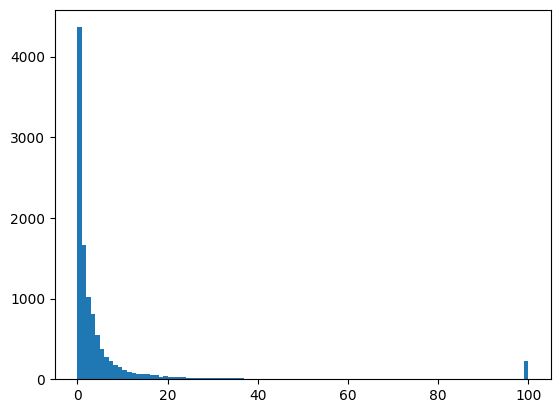

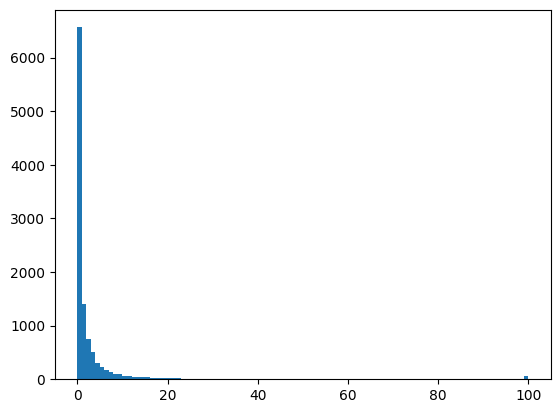

In [34]:
#使用matlibplot绘制分布图
import matplotlib.pyplot as plt
# 纵坐标显示最大数值
plt.hist(lens_source,bins=100)
plt.show()
plt.hist(lens_target,bins=100)
plt.show()


In [35]:
# 统计混合序列的平均长度
def countLens(path):
    with open(path,"r") as f:
        # 按行读取
        lines = f.readlines()
        lens = []
        for line in lines:
            # 按制表符分割
            items = line.strip().split("\t")[2:]
            # 获取每个用户的序列长度
            lens.append(len(items))
            # 求平均值
        print(np.mean(np.array(lens)))
        # max
        print(np.max(np.array(lens)))
        # max 的下标
        print(np.argmax(np.array(lens)))
    

In [36]:
# 统计混合序列中，源领域和目标领域的物品个数
def countSourceTargetItems(path,max_source_item_id):
    print("max_source_item_id: ",max_source_item_id)
    with open(path,"r") as f:
        # 按行读取
        lines = f.readlines()
        lens_source = []
        lens_target = []
        for line in lines:
            # 按制表符分割
            items = line.strip().split("\t")[2:]
            # 统计源领域连续的物品个数
            count_source = 0
            count_target = 0
            # 只取最后100物品作为参考
            items = items[-100:]
            for item in items:
                # 如果物品小于等于源领域的最大值，那么就是源领域的物品
                if int(item.split("|")[0]) <= max_source_item_id:
                    count_source += 1
                else:
                    # 如果物品大于源领域的最大值，那么就是目标领域的物品
                    count_target += 1
            lens_source.append(count_source)
            lens_target.append(count_target)    
    return lens_source,lens_target

lens_source4items,lens_target4items = countSourceTargetItems("../../MGCL/bmc_dataset/Book-Movie/" +"traindata_new.txt",max_source_item_id4_count_consecutive)


max_source_item_id:  236048


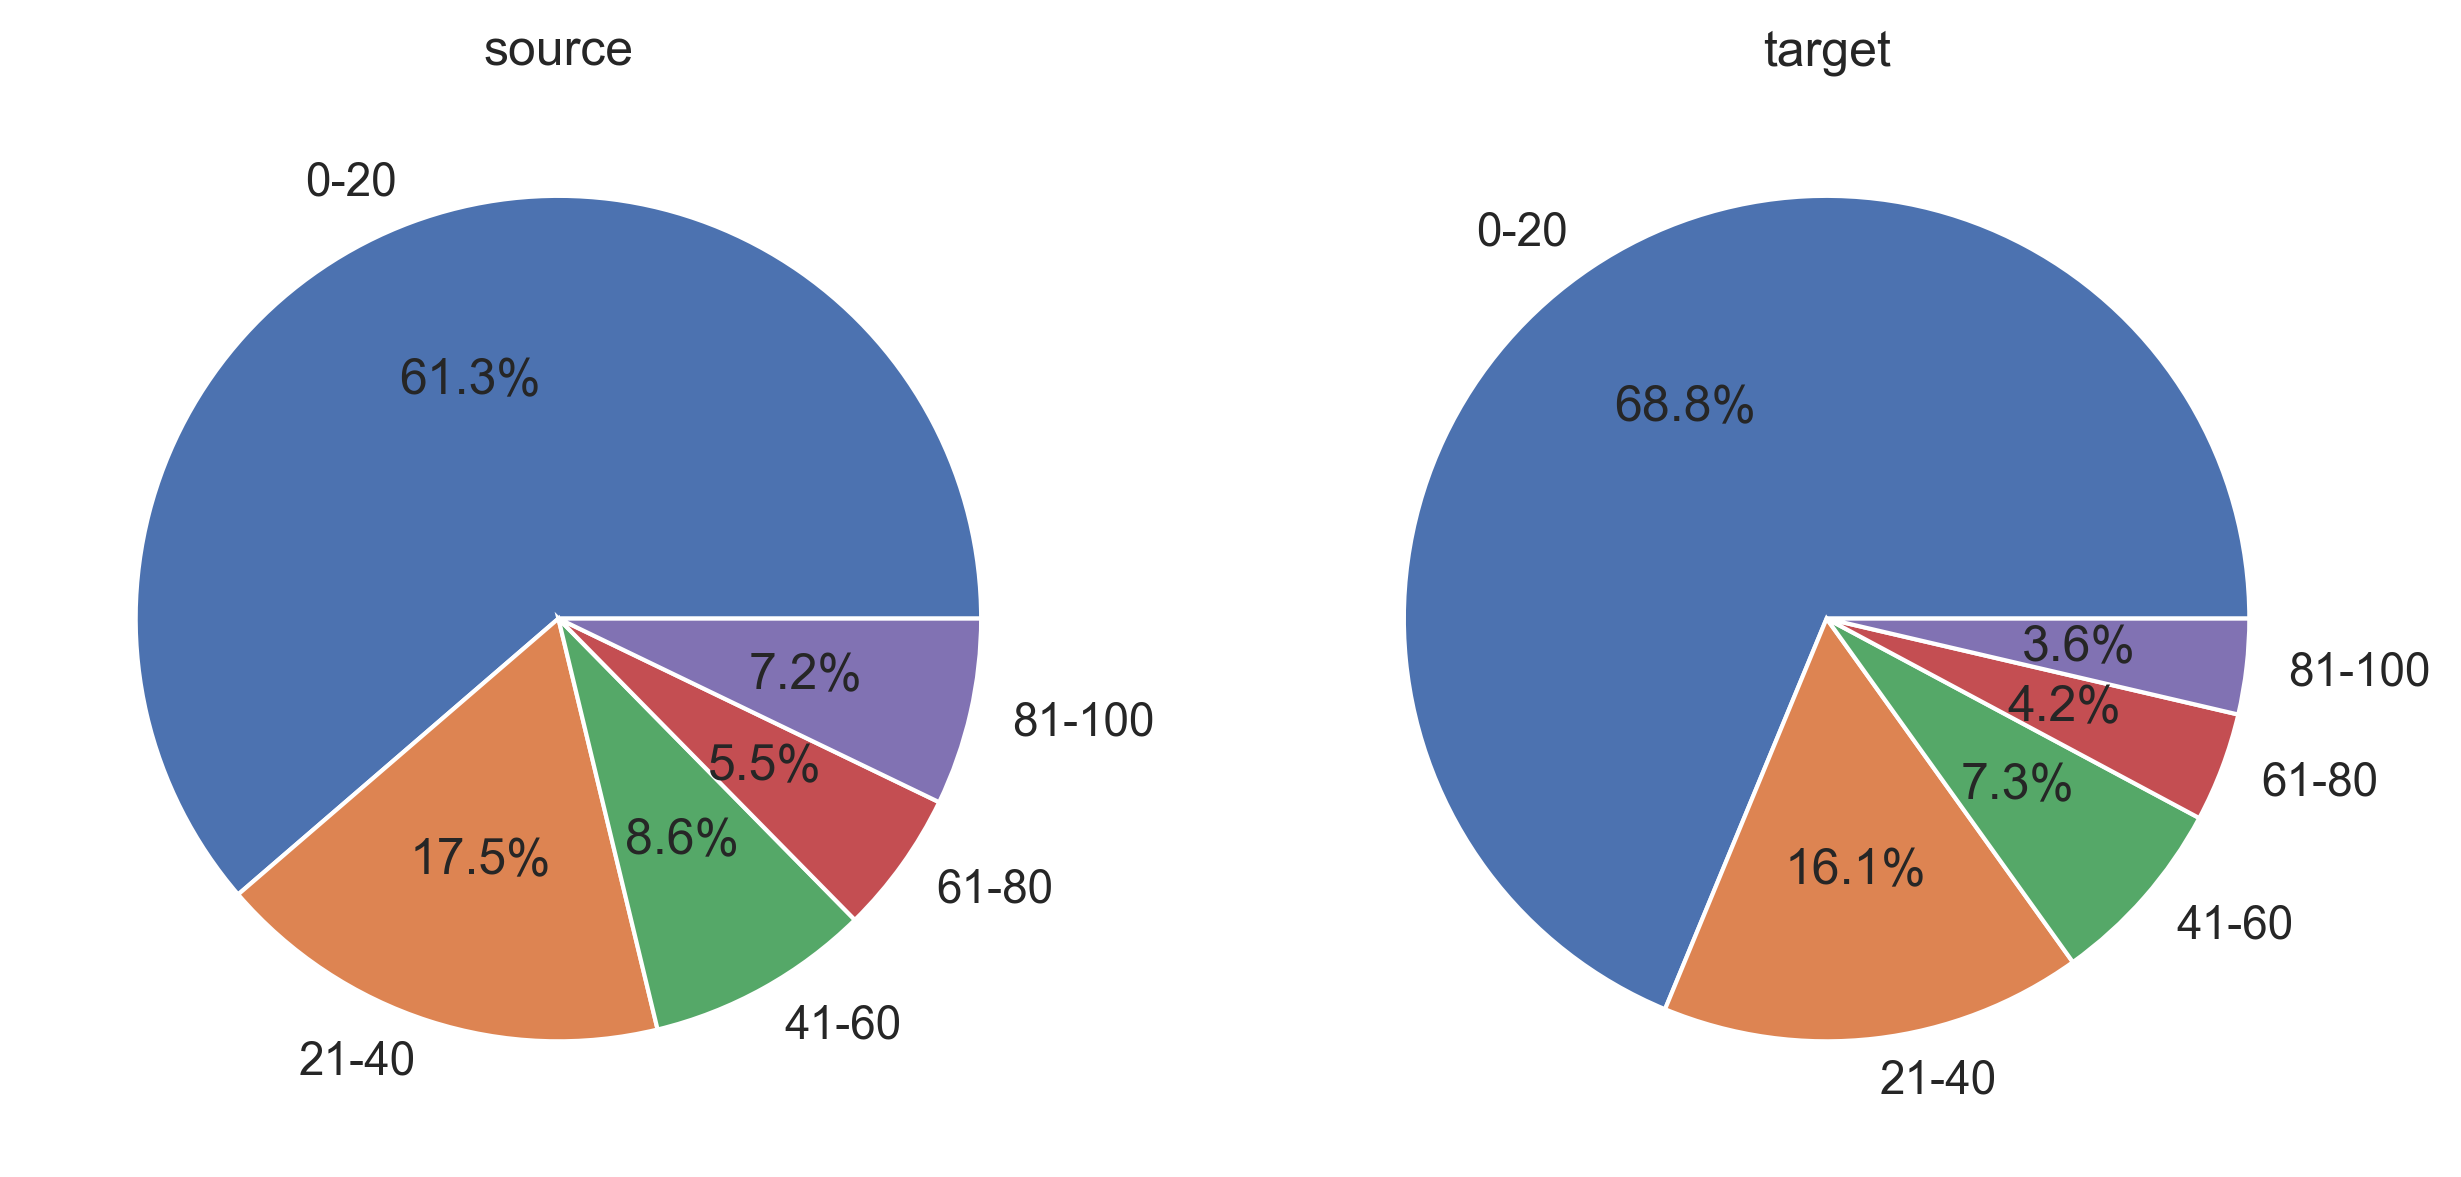

In [37]:
# 统计分布图
import matplotlib.pyplot as plt
import seaborn as sns
def drawPie(lens_source4items ,lens_target4items):
    # 横坐标表示当前是第几个序列，纵坐标表示当前领域的物品个数
    # 绘制图大小设置
    plt.figure(figsize=(10,5),dpi=300)
    # 设置dpi
    #使用 饼图绘制, 个数范围20为一组
    # 0-20 21-40 41-60 61-80 81-100
    pie_arr4source = []
    for i in range(0,100,20):
        pie_arr4source.append(len([item for item in lens_source4items if item >= i and item < i+20]))
    pie_arr4target = []
    for i in range(0,100,20):
        pie_arr4target.append(len([item for item in lens_target4items if item >= i and item < i+20]))
    # 两个图并排显示
    # 使用seaBorn绘制
    sns.set()
    plt.subplot(1,2,1)
    plt.pie(pie_arr4source,labels=["0-20","21-40","41-60","61-80","81-100"],autopct="%1.1f%%")
    plt.title("source")
    plt.subplot(1,2,2)
    plt.pie(pie_arr4target,labels=["0-20","21-40","41-60","61-80","81-100"],autopct="%1.1f%%")
    plt.title("target")
    
    plt.show()
    
drawPie(lens_source4items ,lens_target4items)


In [38]:
# 

In [39]:
# 数量大于50的序列个数占总序列的比例
len([item for item in lens_source if item == 100])

232